In [665]:
import math
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import numpy as np
import warnings
import copy

In [666]:
class StatFunc:
    def count_column(self, column):
        return len(column)

    def mean_column(self, column):
        return sum(column) / len(column)

    def median(self, column):
        sorted_data = sorted(column)
        data_len = len(sorted_data)
        middle = (data_len - 1) // 2
        if middle % 2:
            return sorted_data[middle]
        else:
            return (sorted_data[middle] + sorted_data[middle + 1]) / 2.0

    def var_column(self, column):
        mean = self.mean_column(column)
        return sum(pow(x - mean, 2) for x in column) / len(column)

    def std_column(self, column):
        return math.sqrt(self.var_column(column))

    def max_column(self, column):
        return max(column)

    def min_value(self, column):
        return min(column)

    def quntile(self, column, q):
        data_sorted = sorted(column)

        index = math.ceil(q / 100 * len(data_sorted))

        return data_sorted[index]

    def iqr(self, column):
        return self.quntile(column, 75) - self.quntile(column, 25)

    def print(self, f, column):
        print(f"{f.__name__}: {f(column)}")

    def print_quant(self, f, column, percent):
        print(f"{f.__name__}({percent}): {f(column, percent)}")

    def remove_from_column(self, df, column):
        q1 = self.quntile(column, 25)
        q3 = self.quntile(column, 75)
        iqr = self.iqr(column)
        return df[~((df[column] < (q1 - 1.5 * iqr)) | (df[column] > (q3 + 1.5 * iqr)))]

    def remove_rubbish(self, df):
        for column in df.columns:
            if column != 'id':
                col = df[column]
                df = self.remove_from_column(df, col)
        return df

    def drop_dublicate(self, df):
        # set_df = set()
        # for index, row in df.iterrows():
        #     set_df.add(row.values)
        return df.drop_duplicates()

    def dropna(self, df):
        # for index, row in df.iterrows():
        #     if row.contain(None):
        #         df = df.drop(rows=[row])
        return df.dropna()

    def describe(self, df):
        for column in df.columns:
            if column != 'id':
                col = df[column]
                print("_" * 10)
                print(column)
                self.print(self.count_column, col)
                self.print(self.mean_column, col)
                self.print(self.median, col)
                self.print(self.var_column, col)
                self.print(self.std_column, col)
                self.print(self.min_value, col)
                self.print(self.max_column, col)
                self.print_quant(self.quntile, col, 25)
                self.print_quant(self.quntile, col, 50)
                self.print_quant(self.quntile, col, 75)
                self.print(self.iqr, col)

    def correlation(self, x, y):
        n = len(x)
        sum_x = sum(x)
        sum_y = sum(y)
        sum_x_sq = sum(xi ** 2 for xi in x)
        sum_y_sq = sum(yi ** 2 for yi in y)
        sum_xy = sum(xi * yi for xi, yi in zip(x, y))
        numer = n * sum_xy - sum_x * sum_y
        denom = ((n * sum_x_sq - sum_x ** 2) * (n * sum_y_sq - sum_y ** 2)) ** 0.5
        if denom == 0:
            return 0
        return numer / denom

    def calc_corr(self, df):

        print(f"f0-product corr: {self.correlation(df[df.columns[1]], df[df.columns[-1]])}")
        print(f"f0-f1 corr: {self.correlation(df[df.columns[1]], df[df.columns[2]])}")
        print(f"f0-f3 corr: {self.correlation(df[df.columns[1]], df[df.columns[3]])}")

        print(f"f1-product corr: {self.correlation(df[df.columns[2]], df[df.columns[-1]])}")
        print(f"f1-f2 corr: {self.correlation(df[df.columns[2]], df[df.columns[3]])}")

        print(f"2-product corr: {self.correlation(df[df.columns[3]], df[df.columns[-1]])}")

    def plot_corr_two_column(self, df):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

        ax1.scatter(df[df.columns[1]], df[df.columns[-1]])
        ax2.scatter(df[df.columns[2]], df[df.columns[-1]])
        ax3.scatter(df[df.columns[3]], df[df.columns[-1]])

    def plot_hist_f2(self, df):
        df.hist(column='f2', bins=39)
        mean_value = self.mean_column(df['f2'])
        std = self.std_column(df['f2'])
        print(mean_value + 3 * std)
        plt.axvline(mean_value, color='g', linestyle='dashed', linewidth=2)
        plt.axvline(mean_value - 3 * std, color='r', linestyle='dashed', linewidth=2)
        plt.axvline(mean_value + 3 * std, color='r', linestyle='dashed', linewidth=2)

    def plot_hist_f1(self, df):
        df.hist(column='f1', bins=39)
        mean_value = self.mean_column(df['f1'])
        std = self.std_column(df['f1'])
        print(mean_value + 3 * std)
        plt.axvline(mean_value, color='g', linestyle='dashed', linewidth=2)
        plt.axvline(mean_value - 3 * std, color='r', linestyle='dashed', linewidth=2)
        plt.axvline(mean_value + 3 * std, color='r', linestyle='dashed', linewidth=2)

    def plot_hist_f0(self, df):
        df.hist(column='f0', bins=39)
        mean_value = self.mean_column(df['f0'])
        std = self.std_column(df['f0'])
        print(mean_value + 3 * std)
        plt.axvline(mean_value, color='g', linestyle='dashed', linewidth=2)
        plt.axvline(mean_value - 3 * std, color='r', linestyle='dashed', linewidth=2)
        plt.axvline(mean_value + 3 * std, color='r', linestyle='dashed', linewidth=2)


In [667]:
def fit_linear_regression(x, y,
                          learning_rate=0.00001,
                          epsilon=0.9):
    # Step 1: Insert a new column with ones for y-intercept
    regression = np.c_[x, np.ones(len(x))]

    # Step 2: Declare the weigths with the same width than x
    weights = np.ones(regression.shape[1])

    # Step 3: Implement gradient descent
    norma = 1
    while norma > epsilon:
        # Step 3.1: compute the partial
        y_pred = regression @ weights.T
        partial = regression.T @ (y - y_pred)
        # Step 3.2: compute the norma
        norma = np.sum(np.sqrt(np.square(partial)))

        # Step 3.3: ajust the weights
        weights = weights.T + (learning_rate * partial)
        if (np.isnan(norma)):
            warnings.warn('The model diverged, try to use a smaller learning rate')

    return weights

In [668]:
def predict(w, x):
    return w[:-1] @ np.array(x).T + w[-1]

In [669]:
def MSE(y, y_pred):
    return np.sum(np.square(y - y_pred)) / float(len(y))

In [670]:
def score(y_test, predict):
    print(f"score: {r2_score(y_test, predict)}")

In [671]:
pd.set_option('display.max_columns', None, 'display.width', -1)
df = pd.read_csv("place1.csv")
df = df.drop(columns=['Unnamed: 5'])
df

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


In [672]:
statFunc = StatFunc()

In [673]:
statFunc.describe(df)

__________
f0
count_column: 40
mean_column: 2.0777236500000007
median: 2.338888
var_column: 75.91142878589122
std_column: 8.712716498652485
min_value: -15.001348
max_column: 16.320755
quntile(25): -4.373526
quntile(50): 2.581392
quntile(75): 10.209863
iqr: 14.583389
__________
f1
count_column: 40
mean_column: -4.82101275
median: -4.857165
var_column: 16.400471549630886
std_column: 4.0497495662856595
min_value: -13.659814
max_column: 2.944454
quntile(25): -7.569682
quntile(50): -4.729495
quntile(75): -1.86137
iqr: 5.708312
__________
f2
count_column: 40
mean_column: 2.899392675
median: 2.995379
var_column: 2.887916333229469
std_column: 1.6993870463286076
min_value: -0.00763
max_column: 5.004363
quntile(25): 2.003033
quntile(50): 2.995679
quntile(75): 4.993895
iqr: 2.9908620000000004
__________
product
count_column: 40
mean_column: 79.67595645000002
median: 84.038886
var_column: 2101.540754514007
std_column: 45.84256487713146
min_value: 0.0
max_column: 137.945408
quntile(25): 53.906522
q

In [674]:
df = statFunc.drop_dublicate(df)
df

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
5,HHckp,-3.327590,-2.205276,3.003647,84.038886
6,h5Ujo,-11.142655,-10.133399,4.002382,110.992147
7,muH9x,4.234715,-0.001354,2.004588,53.906522
8,YiRkx,13.355129,-0.332068,4.998647,134.766305
9,jG6Gi,1.069227,-11.025667,4.997844,137.945408


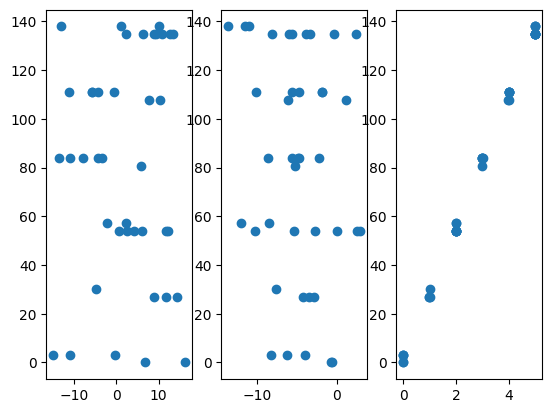

In [675]:
statFunc.plot_corr_two_column(df)

In [676]:
statFunc.calc_corr(df)

f0-product corr: 0.030459257135150693
f0-f1 corr: 0.3818363636842882
f0-f3 corr: 0.05839779077794698
f1-product corr: -0.16756626910263228
f1-f2 corr: -0.15009194233636708
2-product corr: 0.99940521480666


28.215873145957456


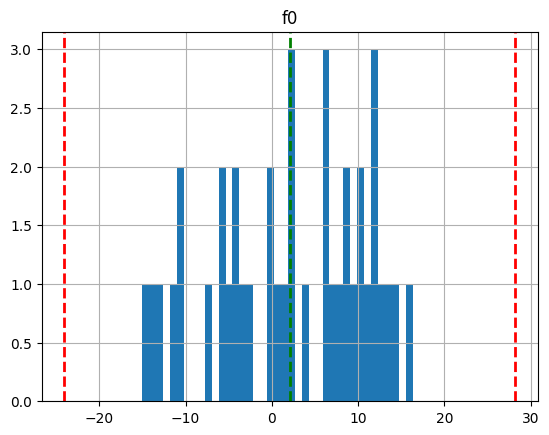

In [677]:
statFunc.plot_hist_f0(df)

7.328235948856979


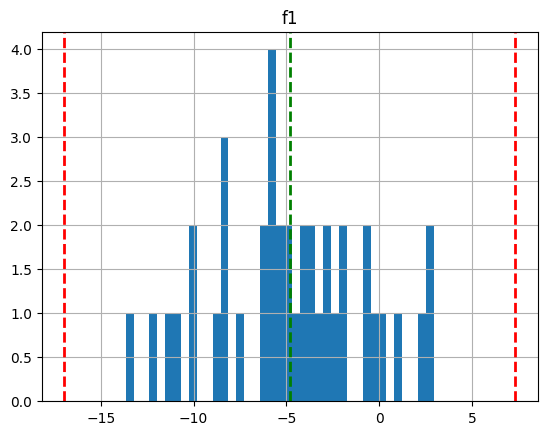

In [678]:
statFunc.plot_hist_f1(df)

7.997553813985823


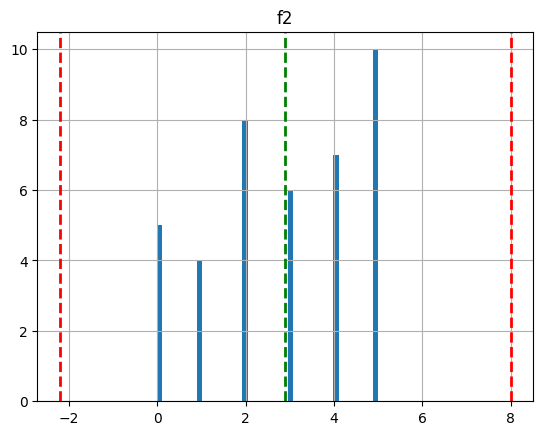

In [679]:
statFunc.plot_hist_f2(df)

In [680]:
regr = linear_model.LinearRegression()
X = df[['f0', 'f1']]
y = df['product']
regr.fit(X, y)
MSE(y, regr.predict(X))

2020.589056297386

In [681]:
regr.score(X, y)

0.0385201657606401

In [682]:
w = fit_linear_regression(X, y)

In [683]:
MSE(y, predict(w, X))

2020.5902206666626

In [684]:
score(y, predict(w, X))

score: 0.03851961170558582


In [685]:
pd.set_option('display.max_columns', None, 'display.width', -1)
df2 = pd.read_csv("place2.csv")
df2 = df2.drop(columns=['Unnamed: 5'])
df2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


In [686]:
statFunc.describe(df2)

__________
f0
count_column: 40
mean_column: -0.07446575000000001
median: -0.387211
var_column: 1.5730997077644875
std_column: 1.2542327167493628
min_value: -2.628353
max_column: 2.378418
quntile(25): -1.146987
quntile(50): -0.307564
quntile(75): 0.927511
iqr: 2.074498
__________
f1
count_column: 40
mean_column: 0.08568272499999999
median: 0.160795
var_column: 2.26400122239125
std_column: 1.5046598361062375
min_value: -3.503145
max_column: 3.16721
quntile(25): -0.570642
quntile(50): 0.269839
quntile(75): 1.077743
iqr: 1.6483849999999998
__________
f2
count_column: 40
mean_column: 2.5239787000000002
median: 2.585887
var_column: 10.918754446362211
std_column: 3.304353862158563
min_value: -5.586433
max_column: 8.635293
quntile(25): 0.912362
quntile(50): 2.898374
quntile(75): 5.362437
iqr: 4.450075
__________
product
count_column: 40
mean_column: 86.42073917499998
median: 90.222465
var_column: 1452.7116199804323
std_column: 38.11445421333529
min_value: 8.704162
max_column: 166.799132
quntil

In [687]:
df2 = statFunc.drop_dublicate(df2)
df2

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
5,LzZXx,-0.758092,0.710691,2.585887,90.222465
6,WBHRv,-0.574891,0.317727,1.773745,45.641478
7,XO8fn,-1.906649,-2.458350,-0.177097,72.480640
8,ybmQ5,1.776292,-0.279356,3.004156,106.616832
9,OilcN,-1.214452,-0.439314,5.922514,52.954532


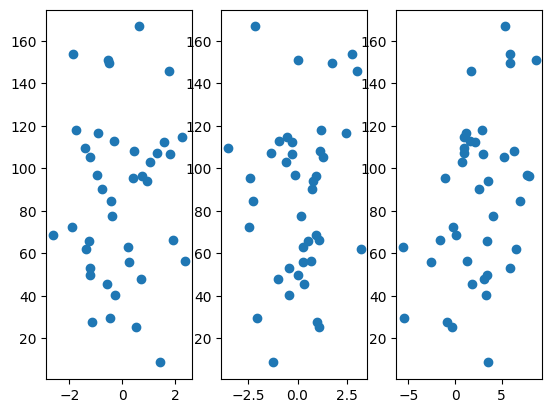

In [688]:
statFunc.plot_corr_two_column(df2)

In [689]:
statFunc.calc_corr(df2)

f0-product corr: 0.03649862049572161
f0-f1 corr: -0.083371936150976
f0-f3 corr: -0.16089439566876296
f1-product corr: 0.13397730887514364
f1-f2 corr: 0.20494451829458796
2-product corr: 0.39779529181951984


3.688232400248088


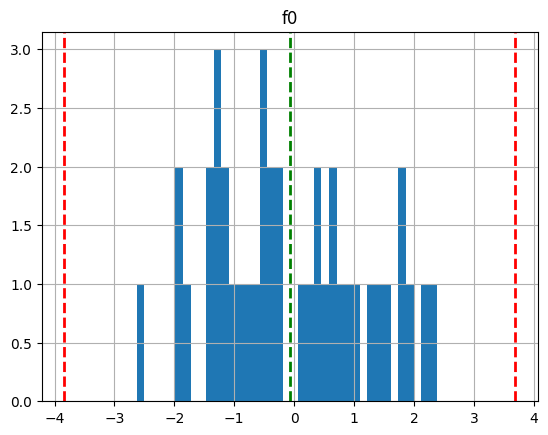

In [690]:
statFunc.plot_hist_f0(df2)

4.599662233318712


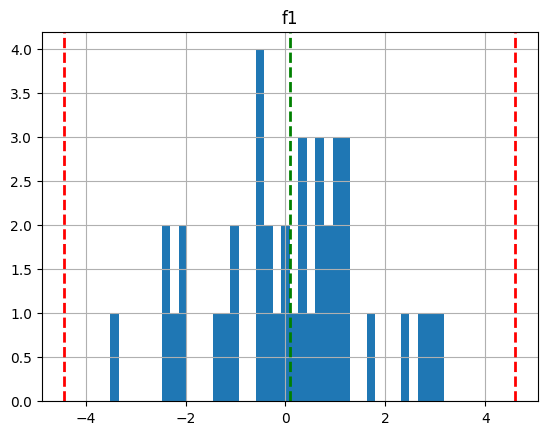

In [691]:
statFunc.plot_hist_f1(df2)

12.437040286475689


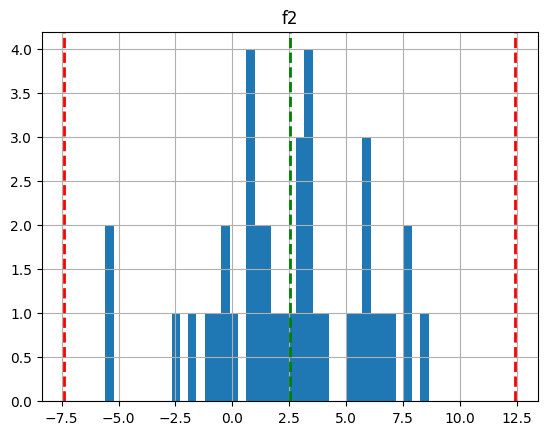

In [692]:
statFunc.plot_hist_f2(df2)

In [693]:
regr = linear_model.LinearRegression()
X = df2[['f0', 'f1', 'f2']]
y = df2['product']
regr.fit(X, y)
regr.score(X, y)

0.17208892383695917

In [694]:
w = fit_linear_regression(X, y)
score(y, predict(w, X))

score: 0.17208855946888213


In [695]:
pd.set_option('display.max_columns', None, 'display.width', -1)
df3 = pd.read_csv("place3.csv")
df3 = df3.drop(columns=['Unnamed: 5'])
df3

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


In [696]:
statFunc.describe(df3)

__________
f0
count_column: 40
mean_column: 0.4904850250000001
median: 0.371066
var_column: 0.7304192671486744
std_column: 0.8546456968526048
min_value: -1.157504
max_column: 2.173381
quntile(25): -0.018578
quntile(50): 0.380913
quntile(75): 1.022732
iqr: 1.04131
__________
f1
count_column: 40
mean_column: 0.23352947499999996
median: 0.15199
var_column: 0.28235968449064935
std_column: 0.5313752765143005
min_value: -0.555728
max_column: 1.130622
quntile(25): -0.131038
quntile(50): 0.153296
quntile(75): 0.788151
iqr: 0.919189
__________
f2
count_column: 40
mean_column: 2.501776650000001
median: 2.372141
var_column: 10.362841389289626
std_column: 3.219136745975484
min_value: -5.62467
max_column: 9.441852
quntile(25): 0.095584
quntile(50): 2.789634
quntile(75): 4.523189
iqr: 4.427605000000001
__________
product
count_column: 40
mean_column: 100.70982177499998
median: 90.483554
var_column: 1479.4641491528737
std_column: 38.46380310308477
min_value: 28.207978
max_column: 168.620776
quntile(2

In [697]:
df3 = statFunc.drop_dublicate(df3)
df3

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541
6,tL6pL,0.645075,0.530656,1.780266,49.055285
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292
8,j9Oui,0.643105,-0.551583,2.372141,113.356160
9,OLuZU,2.173381,0.563698,9.441852,127.910945


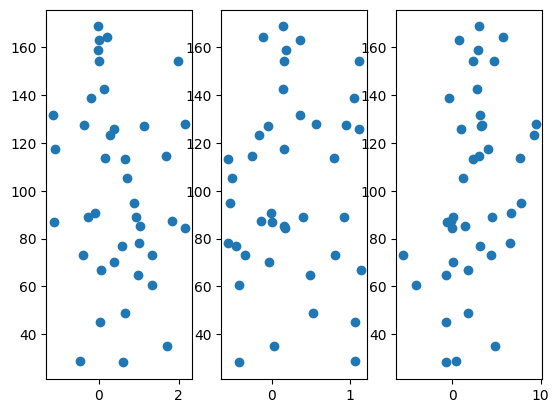

In [698]:
statFunc.plot_corr_two_column(df3)

In [699]:
statFunc.calc_corr(df3)

f0-product corr: -0.15164338509674763
f0-f1 corr: -0.3792497861376987
f0-f3 corr: 0.1778004812149571
f1-product corr: 0.05571071866559952
f1-f2 corr: -0.2209819931162858
2-product corr: 0.3413039584994508


3.0544221155578146


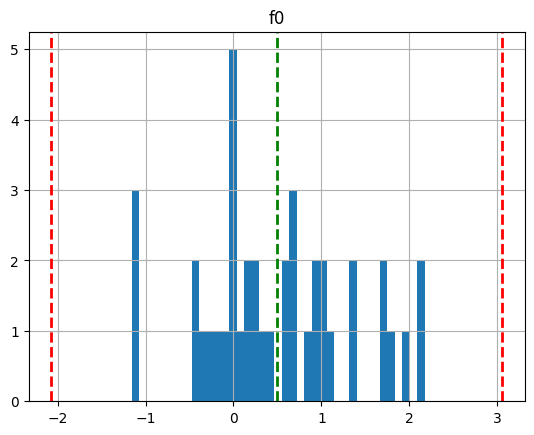

In [700]:
statFunc.plot_hist_f0(df3)

1.8276553045429014


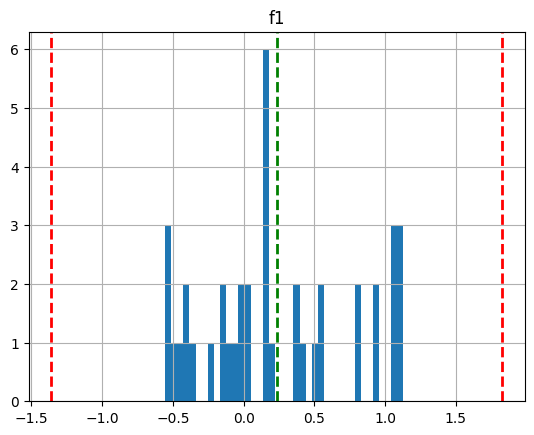

In [701]:
statFunc.plot_hist_f1(df3)

12.159186887926452


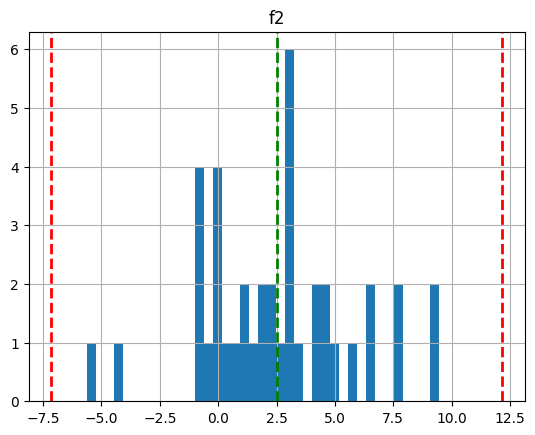

In [702]:
statFunc.plot_hist_f2(df3)

In [703]:
regr = linear_model.LinearRegression()
X = df3[['f0', 'f1', 'f2']]
y = df3['product']
regr.fit(X, y)
regr.score(X, y)

0.16689344905715908

In [704]:
w = fit_linear_regression(X, y)
score(y, predict(w, X))

score: 0.16689273277149763
